In [3]:
import sys
import glob
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# from scipy.interpolate import UnivariateSpline
# from scipy import stats
import pickle

from itertools import chain
from scipy.optimize import curve_fit

# Import ART

sys.path.append('.')
sys.path.append('../ART_iGEM')

from art.core import *
import art.plot as plot

Do not have mpi4py package.
Do not have acor package


# The first step: Loading and structuring the data

The Automated Recommendation tool is used to determine which combination of *Saccharomyces spp.* strain, promotor, secretion peptide and alpha-amylase gene is expected to yield a high alpha-amylase activity. The training data for ART consists of alpha-amylase activity produced by **X** samples out of the possible 640 combinations. This activity was measured using the **X** kit. 



However, the first step is to load in the various data files and make sure they have the correct data type

In [4]:
samples = pd.read_csv('Sample_list.csv', sep=',')

# filtering out the non-existant measurments:

print(len(samples))

samples = samples.loc[samples['Measurement']!='_']
samples['Measurement'] = samples['Measurement'].astype('float64')
samples.info()
#print(len(samples))

#strains_art_oneh = strains.copy().loc[np.logical_or(strains['origin'] == 'lib', strains['origin'] == 'ctr')]



192
<class 'pandas.core.frame.DataFrame'>
Int64Index: 162 entries, 0 to 188
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Line Name    162 non-null    object 
 1   Replicate    162 non-null    object 
 2   Measurement  162 non-null    float64
 3   str_idx      162 non-null    int64  
 4   pro_idx      162 non-null    int64  
 5   sec_idx      162 non-null    int64  
 6   gen_idx      162 non-null    int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 10.1+ KB


The info box above should that the `Line Name` and `Replicate` columns have the Dtype `object`, the has the Dtype `float64` and all other columns have the Dtype `int64`

In [5]:
samples["Line Name"] = samples["Line Name"] + "-" + samples["Replicate"]

samples = samples.loc[:,['Line Name','Measurement','str_idx', 'pro_idx', 'sec_idx', 'gen_idx']]
print(samples.loc[samples['Line Name'].str.contains('#20')])

   Line Name  Measurement  str_idx  pro_idx  sec_idx  gen_idx
57    #20-r0   -13.670093        1       11       18       20
58    #20-r1    -5.395010        1       11       18       20
59    #20-r2   -27.880791        1       11       18       20


In [7]:
samples_art_oneh = pd.get_dummies(data=samples, columns=['str_idx', 'pro_idx', 'sec_idx', 'gen_idx'])
samples_art_oneh.head()

,Line Name,Measurement,str_idx_1,str_idx_2,str_idx_3,str_idx_4,pro_idx_5,pro_idx_6,pro_idx_7,pro_idx_8,...,pro_idx_13,pro_idx_14,sec_idx_15,sec_idx_16,sec_idx_17,sec_idx_18,gen_idx_19,gen_idx_20,gen_idx_21,gen_idx_22
0,#01-r0,-5.919819,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
1,#01-r1,-5.911464,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
2,#01-r2,-5.900195,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
3,#02-r0,-10.527602,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
4,#02-r1,-10.644871,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0


In [8]:
# store the columnnames as parameter setting for ART
colnames = samples_art_oneh.columns[2:].tolist()
print(colnames)

['str_idx_1', 'str_idx_2', 'str_idx_3', 'str_idx_4', 'pro_idx_5', 'pro_idx_6', 'pro_idx_7', 'pro_idx_8', 'pro_idx_9', 'pro_idx_10', 'pro_idx_11', 'pro_idx_12', 'pro_idx_13', 'pro_idx_14', 'sec_idx_15', 'sec_idx_16', 'sec_idx_17', 'sec_idx_18', 'gen_idx_19', 'gen_idx_20', 'gen_idx_21', 'gen_idx_22']


In [9]:
# Pivot the dataframe and change the column names
samples_art_oneh = samples_art_oneh.set_index('Line Name').stack().reset_index()
print(samples_art_oneh)
samples_art_oneh.columns = ['Line Name', 'Measurement Type', 'Value']
samples_art_oneh.head()
samples_art_oneh.to_csv('test.csv')

     Line Name      level_1         0
0       #01-r0  Measurement -5.919819
1       #01-r0    str_idx_1  0.000000
2       #01-r0    str_idx_2  1.000000
3       #01-r0    str_idx_3  0.000000
4       #01-r0    str_idx_4  0.000000
...        ...          ...       ...
3721    #63-r2   sec_idx_18  0.000000
3722    #63-r2   gen_idx_19  0.000000
3723    #63-r2   gen_idx_20  0.000000
3724    #63-r2   gen_idx_21  1.000000
3725    #63-r2   gen_idx_22  0.000000

[3726 rows x 3 columns]


# This section will be handling noice detection and elimination. 

In [10]:
measurement = ['Measurement']

In [11]:
noisy_line_name = utils.find_noisy_data(samples_art_oneh, measurement, percentile=90,plot_flag=False)
samples_art_oneh_filtered = utils.filter_noisy_data(samples_art_oneh, noisy_line_name, measurement, filter_all_replicates=True,plot_flag=False)


../ART_iGEM/art/utility.py:835: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df["Line Name"], df["Replicate"] = df["Line Name"].str.split("-").str


,Value,Measurement Type,Replicate Mean,Replicate Error
Line Name,,,,
#06-r0,-27.908962,Measurement,-17.075898,-10.833064
#06-r1,-8.633705,Measurement,-17.075898,8.442193
#06-r2,-14.685027,Measurement,-17.075898,2.390871
#11-r1,-8.400738,Measurement,-11.702401,3.301663
#11-r2,-14.026769,Measurement,-11.702401,-2.324369
#14-r2,-11.070898,Measurement,-12.863343,1.792445
#16-r0,-11.875708,Measurement,-16.958977,5.083269
#16-r1,-11.631156,Measurement,-16.958977,5.327821
#16-r2,-27.370067,Measurement,-16.958977,-10.411090


,Line Name,Measurement Type,Value
207,#06-r0,Measurement,-27.908962
230,#06-r1,Measurement,-8.633705
253,#06-r2,Measurement,-14.685027
483,#11-r0,Measurement,-12.679695
506,#11-r1,Measurement,-8.400738
529,#11-r2,Measurement,-14.026769
690,#14-r0,Measurement,-13.698265
713,#14-r1,Measurement,-13.820868
736,#14-r2,Measurement,-11.070898
828,#16-r0,Measurement,-11.875708


In [12]:
errors = utils.add_replicate_mean_and_error(samples_art_oneh, ['Measurement'])['Replicate Error']
limit = round(np.percentile(abs(errors), 90),10)
print("The value that delimites the one percent most extreme errors is: {}".format(limit))

The value that delimites the one percent most extreme errors is: 1.1178073144


../ART_iGEM/art/utility.py:835: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df["Line Name"], df["Replicate"] = df["Line Name"].str.split("-").str


In [13]:
errors.abs().mean()*2.5

1.7544316087600198

/home/user/.pyenv/versions/3.9.2/envs/ART_iGEM-3.9.2/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


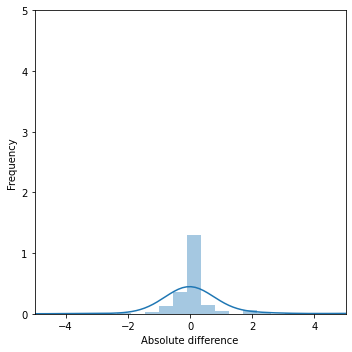

In [14]:
fig, ax = plt.subplots(figsize=(5, 5))
fig.set_tight_layout(True)
sns.distplot(errors, ax=ax);
ax.set_ylim(0, 5)
ax.set_xlim(-5, 5)
ax.set_ylabel('Frequency')
ax.set_xlabel('Absolute difference')
fig.savefig('./figures/Figure 4B.pdf')

/home/user/.pyenv/versions/3.9.2/envs/ART_iGEM-3.9.2/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


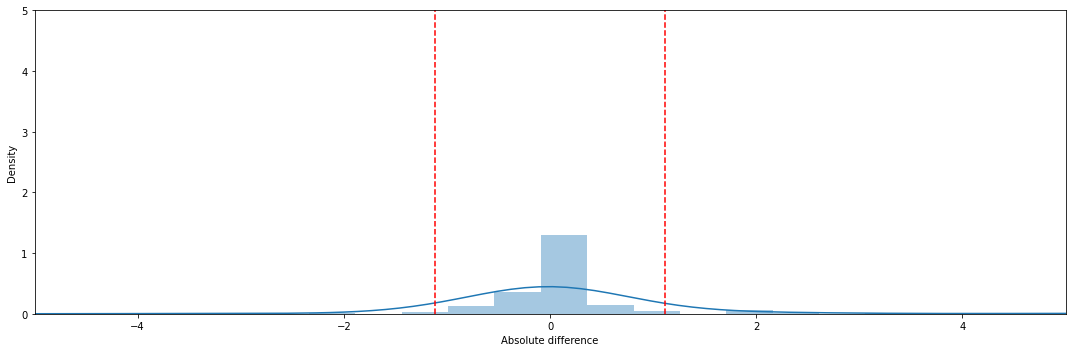

In [15]:
fig, ax = plt.subplots(figsize=(15, 5))
fig.set_tight_layout(True)
sns.distplot(errors, ax=ax)
ax.set_ylim(0, 5)
ax.set_xlim(-5, 5)
ax.axvline(x=limit, ymin=0, color='r', ls='--')
ax.axvline(x=-limit, ymin=0, color='r', ls='--')
ax.annotate(str(round(-limit, 2)), xy=(-limit-50, 0), xytext=(-limit-50, 0.002), color='r')
ax.annotate(str(round(limit, 2)), xy=(limit+5, 0), xytext=(limit+5, 0.002), color='r')
ax.set_xlabel('Absolute difference')
fig.savefig('./figures/Figure 4C.pdf')

# RUNNING ART!!!!!

In [16]:
art_params = {}
art_params['response_vars'] = measurement
art_params['input_vars'] = colnames
art_params['seed'] = 42  # default: None
art_params['num_recommendations'] = 30   
art_params['cross_val'] = True
art_params['recommend'] = False
art_params['output_directory'] = 'results_onehot/'


In [17]:
run_art = True

/home/user/.pyenv/versions/3.9.2/envs/ART_iGEM-3.9.2/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:881: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)
/home/user/.pyenv/versions/3.9.2/envs/ART_iGEM-3.9.2/lib/python3.9/site-packages/pandas/core/internals/blocks.py:938: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)
../ART_iGEM/art/core.py:1312: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferen

Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 36 seconds.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/home/user/.pyenv/versions/3.9.2/envs/ART_iGEM-3.9.2/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:881: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)
/home/user/.pyenv/versions/3.9.2/envs/ART_iGEM-3.9.2/lib/python3.9/site-packages/pandas/core/internals/blocks.py:938: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, y

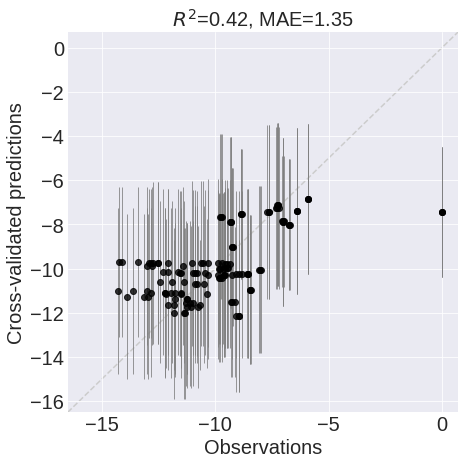

/home/user/.pyenv/versions/3.9.2/envs/ART_iGEM-3.9.2/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:881: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)
/home/user/.pyenv/versions/3.9.2/envs/ART_iGEM-3.9.2/lib/python3.9/site-packages/pandas/core/internals/blocks.py:938: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)
../ART_iGEM/art/core.py:1312: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferen

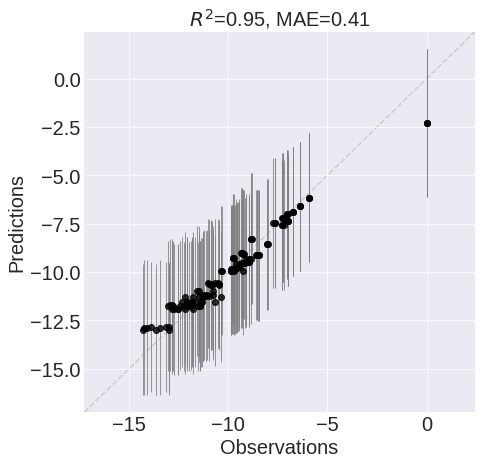

CPU times: user 1h 1min 45s, sys: 58min 34s, total: 2h 20s
Wall time: 53min 39s


In [18]:
%%time
if run_art:
    art = RecommendationEngine(samples_art_oneh_filtered, **art_params)
else:
    with open('results_onehot/art.pkl', 'rb') as output:
        art = pickle.load(output)

## Starting with analysis of the data

In [19]:
art.evaluate_models_cv()

,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,2.219051,567624.841935,1.862821,8.394290,-0.358780
Random Forest Regressor,1.475489,414589.946702,1.308306,3.888733,0.370533
TPOT Regressor,1.306063,447112.907557,1.246043,3.258422,0.472561
Support Vector Regressor,1.444125,522405.364763,1.403152,4.054334,0.343727
Kernel Ridge Regressor,5.853442,230595.347813,2.686836,41.481875,-5.714651
K-NN Regressor,1.949252,429874.421170,1.431189,5.847884,0.053406
Gaussian Process Regressor,1.454492,507736.220528,1.371750,3.997245,0.352968
Gradient Boosting Regressor,1.508493,434871.698528,1.385951,4.196410,0.320729
Ensemble Model,1.350863,459019.441542,1.334487,3.605687,0.416349


Crossvalidated ensemble prediction compared to observations of mean productivity of library and control strains


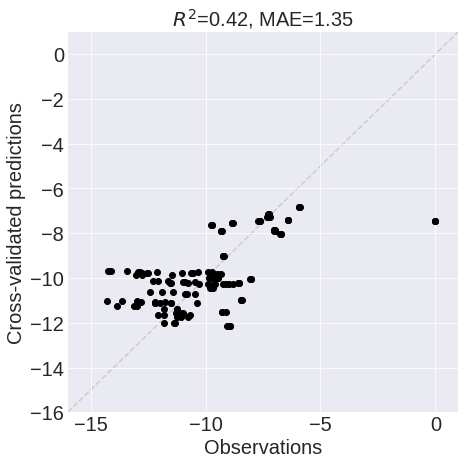

In [21]:
plot.predictions_vs_observations(art, cv_flag=True, errorbars_flag=False, xlim=[[-16, 1]], ylim=[[-16, 1]], log=False)

Ensemble prediction compared to observations of mean productivity of library and control strains


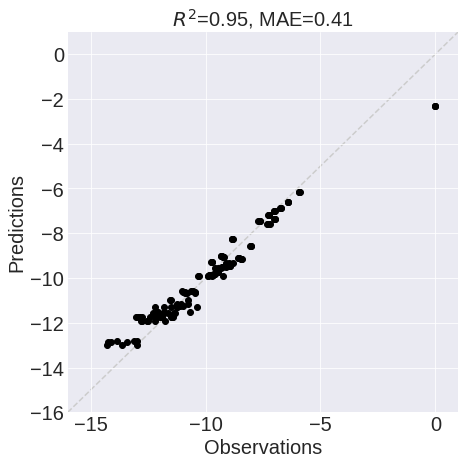

In [22]:
plot.predictions_vs_observations(art, cv_flag=False, errorbars_flag=False, xlim=[[-16, 1]], ylim=[[-16, 1]], log=False)

### learning curves

10 cross-validation runs were performed in parallel running the script `learning_curves_per_set_size.py` with arguments `run_number` and `set_index` (between 0 and 14 for a total of 15 cases). The results were stored in

## TODO:
Adapt the `learning_curves_per_set_size.py` such that it is applicable to our dataset (see Zang and Petersen et al. (2019)).

In [82]:
output_directory = './results_onehot/learning_curves'

In [83]:
num_runs = 10
metrics_all = {}
for run in range(num_runs):
    filename = f'{output_directory}/metrics_train_test_{run+1}.pkl'
    with open(filename, 'rb') as f:
        metrics_all[run] = pickle.load(f) 

FileNotFoundError: [Errno 2] No such file or directory: './results_onehot/learning_curves/metrics_train_test_1.pkl'

### Adding predictions to main dataframe

In [23]:
cv_prediction      = np.array(art.model_df_cv[0]['Predictions']['Ensemble Model'])
print(len(cv_prediction))
print(len(samples_art_oneh_filtered['Line Name'].unique()))
predicted_mean, predicted_std = art.post_pred_stats(art.load_input_data(scale=False))

jbei_library_pred_df = pd.DataFrame({'Line Name' : samples_art_oneh_filtered['Line Name'].unique(),'prediction_JBEI' : predicted_mean.squeeze(), 'cv_prediction_JBEI' : cv_prediction})
jbei_library_pred_df['Line Name'], jbei_library_pred_df['replicate_count'] = jbei_library_pred_df['Line Name'].str.split('-', 1).str
print(jbei_library_pred_df)
# jbei_library_pred_df.head()

138
138
    Line Name  prediction_JBEI  cv_prediction_JBEI replicate_count
0         #01        -6.153637           -6.842782              r0
1         #01        -6.153637           -6.842782              r1
2         #01        -6.153637           -6.842782              r2
3         #02       -10.578168           -9.764507              r0
4         #02       -10.578168           -9.764507              r1
..        ...              ...                 ...             ...
133       #62       -11.282301          -11.371928              r1
134       #62       -11.282301          -11.371928              r2
135       #63        -8.567064          -10.056771              r0
136       #63        -8.567064          -10.056771              r1
137       #63        -8.567064          -10.056771              r2

[138 rows x 4 columns]


/tmp/ipykernel_8208/1845403584.py:7: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  jbei_library_pred_df['Line Name'], jbei_library_pred_df['replicate_count'] = jbei_library_pred_df['Line Name'].str.split('-', 1).str


In [24]:

print(jbei_library_pred_df.head())
strains = pd.read_csv('mock_data.csv', sep=',')
print(strains.head())

strains = pd.merge(strains, jbei_library_pred_df,  how='left', left_on=['Line name', 'Replicate'], right_on = ['Line Name', 'replicate_count'])
strains.head()

  Line Name  prediction_JBEI  cv_prediction_JBEI replicate_count
0       #01        -6.153637           -6.842782              r0
1       #01        -6.153637           -6.842782              r1
2       #01        -6.153637           -6.842782              r2
3       #02       -10.578168           -9.764507              r0
4       #02       -10.578168           -9.764507              r1
  Line name Replicate Measurement  str_idx  pro_idx  sec_idx  gen_idx  \
0       #01        r0           _        2        6       16       22   
1       #01        r1           _        2        6       16       22   
2       #01        r2           _        2        6       16       22   
3       #02        r0           _        4       11       18       19   
4       #02        r1           _        4       11       18       19   

   measurement  
0     0.829131  
1     0.333064  
2     0.871142  
3     0.937158  
4     0.054991  


,Line name,Replicate,Measurement,str_idx,pro_idx,sec_idx,gen_idx,measurement,Line Name,prediction_JBEI,cv_prediction_JBEI,replicate_count
0,#01,r0,_,2,6,16,22,0.829131,#01,-6.153637,-6.842782,r0
1,#01,r1,_,2,6,16,22,0.333064,#01,-6.153637,-6.842782,r1
2,#01,r2,_,2,6,16,22,0.871142,#01,-6.153637,-6.842782,r2
3,#02,r0,_,4,11,18,19,0.937158,#02,-10.578168,-9.764507,r0
4,#02,r1,_,4,11,18,19,0.054991,#02,-10.578168,-9.764507,r1


In [25]:
num_strains = 4
indeces_strains = np.array(range(1,num_strains+1))
num_promoters = 10
indeces_promoters = np.array(range(num_strains+1, num_strains+num_promoters+1))
num_secretion_signals = 4
indeces_secretion = np.array(range(num_strains+num_promoters+1, num_strains+num_promoters+num_secretion_signals+1))
num_genes = 4

In [26]:
num_of_promoters = 10
num_of_genes = 4
num_of_designs = 4*10*4*4
num_of_promoters_onehot = art.num_input_var

designs = np.zeros((num_of_designs, num_of_promoters_onehot))

i = 0

promoters = np.eye(10)
seqretion = np.eye(4)

for p1 in seqretion:
    for p2 in promoters:
        for p3 in seqretion:
            for p4 in seqretion:
                designs[i,:] = np.hstack((p1,p2,p3,p4)).astype(int)
                i+=1

print(designs[:5])


[[1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.]]


Calculate mean predicted production and standard deviation for all possible designs.

In [27]:
pp_mean, pp_std = art.post_pred_stats(designs)

The relative engineering accuracy is set to one percent to make sure recommendations are different from the input data.

In [28]:
art.rel_eng_accuracy = 0.01

### Exploitative approach

Objective function is defined as the mean predicted production (the parameter for exploration is set to 𝛼=0
).

In [29]:
obj_func = pp_mean 
data = np.hstack((designs, obj_func, obj_func))
print(data)

[[  1.           0.           0.         ...   0.         -10.08300806
  -10.08300806]
 [  1.           0.           0.         ...   0.         -11.98663379
  -11.98663379]
 [  1.           0.           0.         ...   0.         -10.1023104
  -10.1023104 ]
 ...
 [  0.           0.           0.         ...   0.         -12.2608868
  -12.2608868 ]
 [  0.           0.           0.         ...   0.         -10.45078716
  -10.45078716]
 [  0.           0.           0.         ...   1.          -9.04147459
   -9.04147459]]


In [31]:
art.recommend(data=data)
ind_max = np.argmax(art.recommendations.values[:,-1])
mean, std = art.post_pred_stats(art.recommendations.values[ind_max,:-1])
print(f'Mean and standard deviation of the recommendation with the highest predicted production are: {mean[0][0]:.2f}, {std[0][0]:.2f}')

../ART_iGEM/art/core.py:1610: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(new_rec[l] - previous_points[k][l])
../ART_iGEM/art/core.py:1610: RuntimeWarning: divide by zero encountered in double_scalars
  np.abs(new_rec[l] - previous_points[k][l])


Mean and standard deviation of the recommendation with the highest predicted production are: -2.86, 1.94


In [32]:
print(art.recommendations.index)

df_rec_categ_exploit = pd.DataFrame(index=art.recommendations.index, columns=['strain','promoter','seqretion','gene',measurement[0]])
for i in range(art.num_recommendations):
    rec = art.recommendations.iloc[i][np.round(art.recommendations.values[i,:]).astype('int64') != 0]
    print(rec.index)
    df_rec_categ_exploit.iloc[i][('strain','promoter','seqretion','gene')] = [int(float(p.split('_')[2])) for p in rec.index[:-1]]
    df_rec_categ_exploit.iloc[i][measurement] = rec[measurement]
df_rec_categ_exploit

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
           dtype='int64')
Index(['str_idx_4', 'pro_idx_10', 'sec_idx_16', 'gen_idx_22', 'Measurement'], dtype='object')
Index(['str_idx_1', 'pro_idx_10', 'sec_idx_16', 'gen_idx_22', 'Measurement'], dtype='object')
Index(['str_idx_3', 'pro_idx_10', 'sec_idx_16', 'gen_idx_22', 'Measurement'], dtype='object')
Index(['str_idx_2', 'pro_idx_10', 'sec_idx_15', 'gen_idx_22', 'Measurement'], dtype='object')
Index(['str_idx_2', 'pro_idx_10', 'sec_idx_18', 'gen_idx_22', 'Measurement'], dtype='object')
Index(['str_idx_2', 'pro_idx_10', 'sec_idx_17', 'gen_idx_22', 'Measurement'], dtype='object')
Index(['str_idx_1', 'pro_idx_10', 'sec_idx_15', 'gen_idx_22', 'Measurement'], dtype='object')
Index(['str_idx_4', 'pro_idx_10', 'sec_idx_15', 'gen_idx_22', 'Measurement'], dtype='object')
Index(['str_idx_4', 'pro_idx_10', 'sec_idx_18', 'gen_idx_22', 'Measurement'],

,strain,promoter,seqretion,gene,Measurement
0,4,10,16,22,-2.861111
1,1,10,16,22,-2.890783
2,3,10,16,22,-3.266204
3,2,10,15,22,-3.555824
4,2,10,18,22,-3.556172
5,2,10,17,22,-3.758143
6,1,10,15,22,-3.908129
7,4,10,15,22,-3.955315
8,4,10,18,22,-3.991896
9,1,10,18,22,-4.069883


In [33]:
df_rec_categ_exploit.nunique()

strain          4
promoter        7
seqretion       4
gene            1
Measurement    30
dtype: int64